In [2]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")

library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)

library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

# CHR

In [3]:
## CHI_or
n_k_lst=21*abs(c(1:7)-4)+20
pi_k_lst=n_k_lst/sum(n_k_lst)

sd_or_lst=(1+1/c(1:7))
clu_k=rep(c(1:7),each=n_k_lst)
K=length(unique(clu_k))

mu_or_1=(1/3)*(1:K)^2
mu_or_2=-10*(1:K)^(1/2)

mu_mat_or=cbind(mu_or_1,mu_or_2)
mu_v_or=pi_k_lst%*%mu_mat_or

for(i in 1:K){
    if(i==1){
        m_or=pi_k_lst[i]*mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }else{
        m_or=m_or+pi_k_lst[i]*mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }
}

for(i in 1:K){
    if(i==1){
        wc_or=pi_k_lst[i]*sum(diag(sd_or_lst[i]^2*diag(2)))
    }else{
        wc_or=wc_or+pi_k_lst[i]*sum(diag(sd_or_lst[i]^2*diag(2)))
    }
}

bc_or=sum(diag(m_or-t(mu_v_or)%*%mu_v_or))
wc_or=wc_or
CHI_or=bc_or/wc_or

## CHI_no
mu_no=12.3
mu_mat_no=mu_no*diag(K)
mu_v_no=apply(mu_mat_no,2,mean)

for(i in 1:K){
    if(i==1){
        m_no=mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }else{
        m_no=m_no+mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }
}
bc_no=sum(diag(m_no/K-mu_v_no%*%t(mu_v_no)))
wc_no=sum(diag(K^(-1)*K*diag(K)))

CHI_no=bc_no/wc_no
cat("CHR:",sqrt(CHI_no/CHI_or))

CHR: 1.002369

# Function

In [4]:
setting_K7_unbalanced<-function(mu_or=1,n_k_lst=21*abs(c(1:7)-4)+20,
                                p=20,seed=1234,mu_no=1){
    set.seed(seed)
    K=length(n_k_lst)
    n=sum(n_k_lst)
    
    for(i in 1:K){
        if(i==1){
            clu_k=c(rep(i,n_k_lst[i]))
        }else{
            clu_k=c(clu_k,rep(i,n_k_lst[i]))
        }
    }
    
    mu_1=mu_or*(1/3)*(clu_k)^2
    mu_2=mu_or*(-10)*(clu_k)^(1/2)
    
    # Data generation
    x1=mu_1+rnorm(n,0,(1+1/clu_k))
    x2=mu_2+rnorm(n,0,(1+1/clu_k))
    
    data_x=scale(cbind(x1,x2))
    
    ############################
    # Data corresponding to nominal clusters
    mu_no_mat=diag(K)
    
    # Nominal cluster generation
    x_no=matrix(0,n,ncol(mu_no_mat))
    p_lst=runif(n,0,1)
    clu_no=p_lst*0
    for(i in 1:K){
        clu_no=clu_no+(p_lst>=((i-1)/8))
    }
    #clu_no
    for(i in 1:nrow(x_no)){
        x_no[i,]=mu_no*mu_no_mat[clu_no[i],]
    }

    for(i in 1:ncol(x_no)){
        x_no[,i]=x_no[,i]+rnorm(nrow(x_no),0,1)
    }

    colnames(x_no)=paste("x_no",1:(ncol(x_no)),sep="_")
    
    ###############################
    # Noise variables
    p_e=p-ncol(data_x)-ncol(x_no)
    noise_mat=nor_minmax(matrix(rnorm(n*p_e,0,1),n,p_e))
    colnames(noise_mat)=paste("noise",1:(ncol(noise_mat)),sep="_")
    
    data=scale(cbind(data_x,x_no,noise_mat))
    
    
    
    ## clustering
    kk=K
    pam <- pam(data,kk)
    km <- KMeans_rcpp(data,kk)
    mocl <- MOCL_wcss(Xf=data,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=50),delta=0.01)
    skm <- Sparse_km(data=data,kk=kk,nperms_n=10)
    varsel <- VarSelCluster(data, kk, nbcores = 2, crit.varsel = 'BIC') 
    
    
    # clusters
    cluster_mat=rbind(mocl$cluster,
                     skm$cluster_best,
                     skm$cluster_1sd,
                     fitted(varsel),
                     km$cluster,
                     pam$cluster)
    
    rownames(cluster_mat)=c("MOCL_wcss","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    
    sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)),
                    skm$sparse_best,skm$sparse_1sd,
                     slot(slot(varsel,'model'),'omega'))
    
    rownames(sparse_mat)=c("MOCL","SKM_best","SKM_1sd","VSL")
    
    rand_mat=t(matrix(c(rand.index(clu_k,mocl$cluster),
                         rand.index(clu_k,skm$cluster_best),
                         rand.index(clu_k,skm$cluster_1sd),
                         rand.index(clu_k,fitted(varsel)),
                         rand.index(clu_k,km$cluster),
                         rand.index(clu_k,pam$cluster))))
    
    colnames(rand_mat)=c("MOCL","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    kendall=cor(clu_k,mocl$cluster,method="kendall")
    
    
    if(p==ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                        c(rep(0,nrow(sparse_mat))))
    }
    if(p>ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                    apply(sparse_mat[,c((ncol(data_x)+1):ncol(sparse_mat))],1,mean))
    }
    
    rand_no=rand.index(clu_k,clu_no)
    return(list(cluster=clu_k,clu_no=clu_no,rand_no=rand_no,cluster_mat=cluster_mat,data=data,mocl_lam=mocl$lambda_sel_mat,
                sparse_mat=sparse_mat,rand_mat=rand_mat,TP_FP_mat=TP_FP_mat,kendall=kendall,
                fx_mocl=mocl$fx,
                coef_mocl=mocl$coef,
                weight_skm=skm$weigth_best,weight_skm_1sd=skm$weigth_1sd))
}

# Simulation

In [5]:
iter_n=100

In [ ]:
ss=292
set.seed(ss)
seed_r=round(runif(20000,1,20000))
mu_nom=12.3
models_0=list()
models_1=list()
models_2=list()
models_3=list()
models_4=list()
models_5=list()
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+2]
    models_0[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*0,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+3]
    models_1[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*0.2,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[1*i+400]
    models_2[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*0.4,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+5]
    models_3[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*0.6,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+6]
    models_4[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*0.8,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+7]
    models_5[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*1.0,seed=seed_rr)   
}
Sys.time()

In [ ]:
models_6=list()
models_7=list()
models_8=list()
models_9=list()
models_10=list()
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+8]
    models_6[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*1.2,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[12*i+22]
    models_7[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*1.4,seed=seed_rr)   
}

Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+15]
    models_8[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*1.6,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+19]
    models_9[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*1.8,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[12*i+11]
    models_10[[i]]=setting_K7_unbalanced(mu_or=1,mu_no=mu_nom*2.0,seed=seed_rr)   
}
Sys.time()

In [23]:
length(models_10)

[1] 100

# Results

In [29]:
mm_lst=list()
mm_lst[[1]]=models_0
mm_lst[[2]]=models_1
mm_lst[[3]]=models_2
mm_lst[[4]]=models_3
mm_lst[[5]]=models_4
mm_lst[[6]]=models_5
mm_lst[[7]]=models_6
mm_lst[[8]]=models_7
mm_lst[[9]]=models_8
mm_lst[[10]]=models_9
mm_lst[[11]]=models_10

saveRDS(mm_lst,file="add_simul_no.RData")

### Rand index

In [32]:
for(i in 1:length(mm_lst)){
    if(i==1){
        rand_mat=round(rand_summary(mm_lst[[i]])$rand_mean[-2],3)
    }else{
        rand_mat=rbind(rand_mat,round(rand_summary(mm_lst[[i]])$rand_mean[-2],3))
    }
}

for(i in 1:length(mm_lst)){
    if(i==1){
        rand_no_mat=round(rand_no_summary(mm_lst[[i]])$rand_no_mean[-2],3)
    }else{
        rand_no_mat=rbind(rand_no_mat,round(rand_no_summary(mm_lst[[i]])$rand_no_mean[-2],3))
    }
}

### Variable Selection

In [33]:
var_acc<-function(models,index=c(1,2,3)){
    for(i in 1:length(models)){
        if(i==1){
            acc=apply(models[[i]]$sparse_mat[,index],1,mean)
        }else{
            acc=rbind(acc,apply(models[[i]]$sparse_mat[,index],1,mean))
        }
    }
    acc_mean=apply(acc,2,mean)
    return(acc_mean)
}

for(i in 1:length(mm_lst)){
    if(i==1){
        tp_ord=var_acc(models=mm_lst[[i]],index=c(1,2))[-2]
        tp_nom=var_acc(models=mm_lst[[i]],index=c(3:9))[-2]
        tp_noi=var_acc(models=mm_lst[[i]],index=c(10:20))[-2]
    }else{
        tp_ord=rbind(tp_ord,var_acc(models=mm_lst[[i]],index=c(1,2))[-2])
        tp_nom=rbind(tp_nom,var_acc(models=mm_lst[[i]],index=c(3:9))[-2])
        tp_noi=rbind(tp_noi,var_acc(models=mm_lst[[i]],index=c(10:20))[-2])
    }
}

In [34]:
####################################################
# Save the results
saveRDS(mm_lst,file="Simulation_CHI_add_K7_nom_results.RData")

CHR=c(0:10)/5+0.1
rownames(rand_mat)=rownames(rand_no_mat)=CHR
rownames(tp_ord)=rownames(tp_nom)=rownames(tp_noi)=CHR
#####################################################
# Save the mean values of rand index
RI_lst=list()
RI_lst[["rand_or"]]=rand_mat
RI_lst[["rand_no"]]=rand_no_mat

saveRDS(RI_lst,file="Simulation_CHI_add_K7_nom_RandIndex.RData")

#####################################################
# Save the mean values of variable selection accuracy
Var_sel_lst=list()
Var_sel_lst[["tp_ord"]]=tp_ord
Var_sel_lst[["tp_nom"]]=tp_nom
Var_sel_lst[["tp_noise"]]=tp_noi

saveRDS(Var_sel_lst,file="Simulation_CHI_add_K7_nom_Varsel.RData")

### Kendall

In [35]:
kendall_summary<-function(models){
    for(i in 1:length(models)){
        if(i==1){
            kendall_lst=models[[i]]$kendall
        }else{
            kendall_lst=c(kendall_lst,models[[i]]$kendall) # kendall_correlation values of 100iterations
                                                           # between MOCL clusters and real clusters
        }
    }
    kendall_lst=abs(kendall_lst)
    return(kendall_lst)
}

for(i in 1:length(mm_lst)){
    kendalls_mean=mean(kendall_summary(mm_lst[[i]]))
    kendalls_1se=sd(kendall_summary(mm_lst[[i]]))/sqrt(100)
    if(i==1){
        kendall_mean_lst=kendalls_mean
        kendall_1se_lst=kendalls_1se
    }else{
        kendall_mean_lst=c(kendall_mean_lst,kendalls_mean)
        kendall_1se_lst=c(kendall_1se_lst,kendalls_1se)
    }
}

kendall_lst=list()
kendall_lst[["mean"]]=kendall_mean_lst
kendall_lst[["se"]]=kendall_1se_lst

###############################
# Save
saveRDS(kendall_lst,file="Simulation_CHI_add_K7_nom_kendall.RData")

# Plot

In [88]:
skm_var=-2 # 
rand_mat=rand_mat[,skm_var]
rand_no_mat=rand_no_mat[,skm_var]

tp_ord=tp_ord[,skm_var]
tp_nom=tp_nom[,skm_var]
tp_noi=tp_noi[,skm_var]

## Rand index

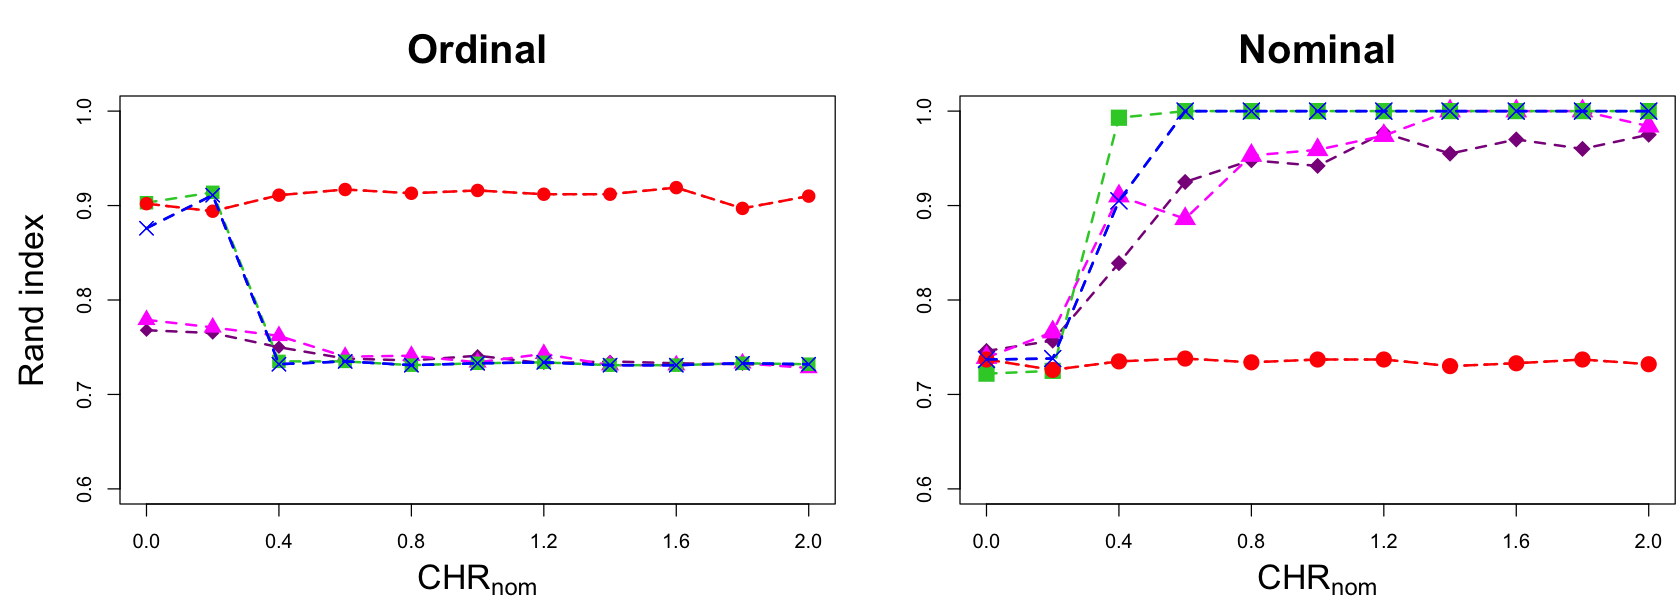

In [89]:
CHR=c(0:10)/5


options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))

pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="Rand index",main="Ordinal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.8)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Nominal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.8)
}

## Variable selection

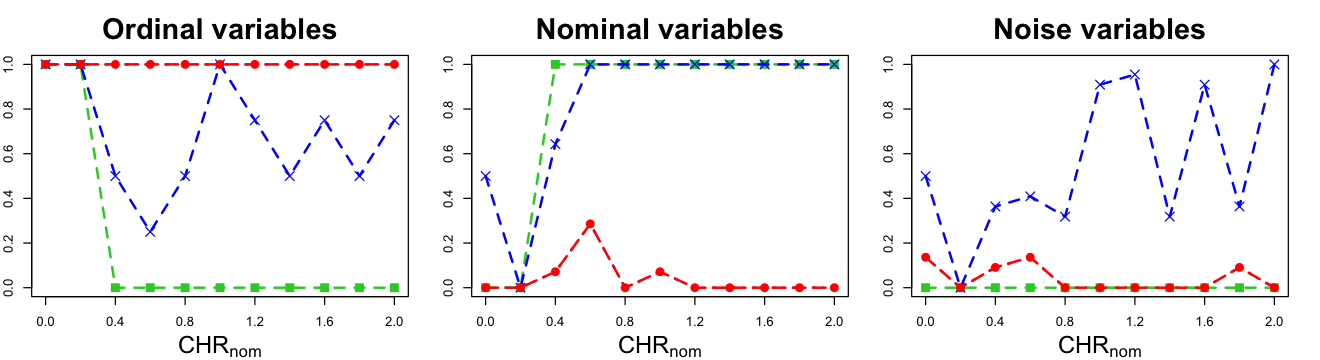

In [90]:

options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Ordinal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Nominal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{nom}$"),ylab="",main="Noise variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1)-0.1)

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

## Kendall correlation with ordinal variables

In [91]:
kendall_summary<-function(models){
    for(i in 1:length(models)){
        if(i==1){
            kendall_lst=models[[i]]$kendall
        }else{
            kendall_lst=c(kendall_lst,models[[i]]$kendall)
        }
    }
    kendall_lst=abs(kendall_lst)
    return(kendall_lst)
}

for(i in 1:length(mm_lst)){
    if(i==1){
        kendalls=kendall_summary(mm_lst[[i]])
    }else{
        kendalls=c(kendalls,kendall_summary(mm_lst[[i]]))
    }
}

In [92]:
cat("kendall mean :",round(mean(kendalls),3))
print("-----------------")
cat("kendall 2se :",round(2*sd(kendalls)/sqrt(length(kendalls)),4))

kendall mean : 0.935[1] "-----------------"
kendall 2se : 0.0046

## Coefficients boxplot

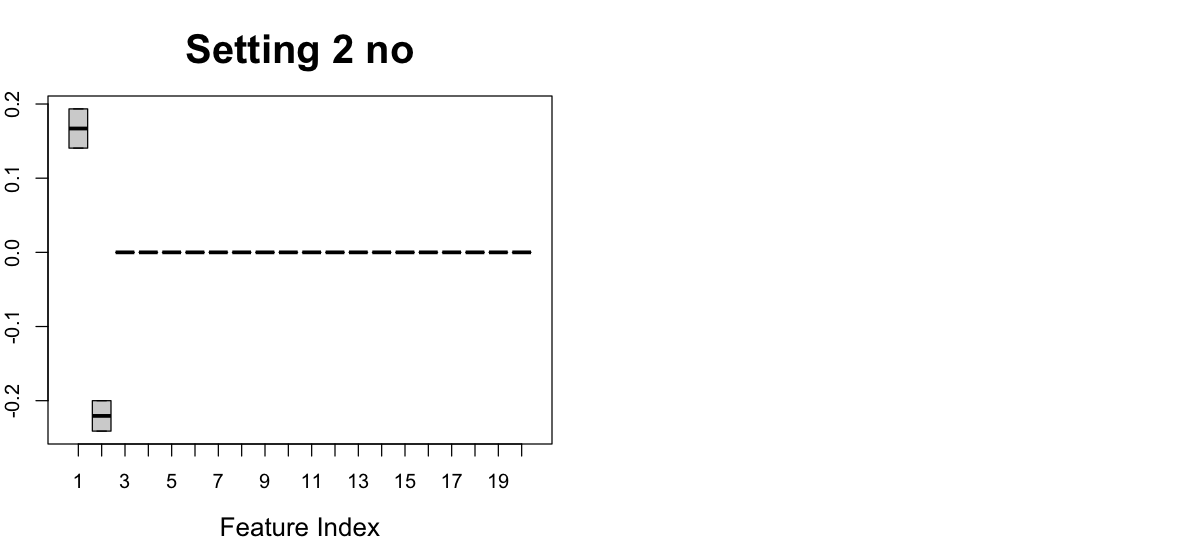

In [84]:
options(repr.plot.width = 10, repr.plot.height = 4.5)
par(mfrow=c(1,2))
par(mar=c(4,2,4,2))


m=coef_mocl_summary(models_10)
#m$coef_mocl_m

boxplot(m$coef_mocl_m,main="Setting 2 no",cex.main=2,cex.lab=1.3,#,xaxt='n',
        xlab="Feature Index",ylab="mean coefficients",cex.axis=1)
#axis(1,at=c(1:20))